### 随机变量 w 的PDF

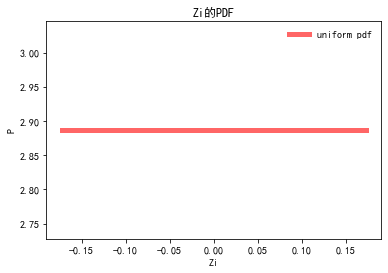

In [97]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

zi = uniform(loc=-np.sqrt(3)/10, scale=2*np.sqrt(3)/10)

# ppf=0.001, pdf=0.999 时 x 的值
x = np.linspace(start=zi.ppf(0.001),
                stop=zi.ppf(0.999),
                num=100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, zi.pdf(x),
       'r-', lw=5, alpha=0.6, label='uniform pdf')
ax.legend(loc='best', frameon=False)
plt.title("Zi的PDF")
plt.xlabel("Zi")
plt.ylabel("P")
plt.show()

In [26]:
def get_w(zi, random_state=1):
    # 生成500个随机变量
    variates = zi.rvs(random_state=random_state, size=500)
    w = np.sum(variates)
    return w

# 采样
sample_num = 2000
data = []
for i in range(sample_num):
    w = get_w(zi, random_state=i)
    data.append(w)
data = np.vstack(np.array(data).ravel())
data[:10]

array([[-0.58930578],
       [ 1.43363928],
       [-1.21796936],
       [-0.86860824],
       [ 3.3473108 ],
       [ 0.02512843],
       [ 1.45743678],
       [ 0.35167155],
       [-1.78057707],
       [ 0.17837543]])

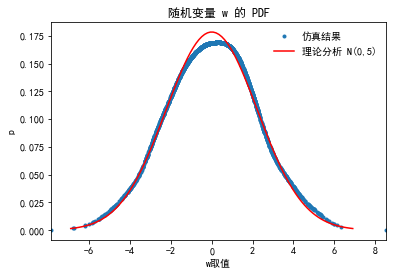

In [62]:
# 密度函数预估
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)
logkde = kde.score_samples(data)

fig, ax = plt.subplots(1, 1)

# 仿真结果
ax.set_xlim([data.min(), data.max()])
ax.plot(data.ravel(), np.exp(logkde), '.', label='仿真结果')

# 理论分析
from scipy.stats import norm
gauss = norm(loc=0, scale=np.sqrt(5))
x_ = np.linspace(gauss.ppf(0.001), gauss.ppf(0.999), 100)
ax.plot(x_, gauss.pdf(x_), 'r-', label='理论分析 N(0,5)')

ax.legend(loc='best', frameon=False)
plt.title("随机变量 w 的 PDF")
plt.xlabel("w取值")
plt.ylabel("p")
plt.show()

In [28]:
# E(z)=0, D(z)=0.01 => D(w)=0, D(w)=5.0
np.mean(data), np.var(data)


(-0.002402532163769255, 5.008268267124216)

#### 估计 A 的值

In [94]:
def mse(y: np.array, y_hat: np.array):
    return np.mean(np.square(y-y_hat))


kth_mse = {}
for k in [1,2,4,6,8,10,12,14,16]:

    epochs = []
    y_n = []
    ml_mses = []
    ls_mses = []
    lmmse_mses = []
    A = norm().rvs(random_state=10, size=1)
    N = 1000

    for i in range(N+1):

        y_i = k*A + get_w(zi, random_state=i)
        y_n.append(y_i)

        # ML 计算 MSE
        A_hat_ml = np.mean(np.array(y_n))/k

        # LS(伪逆) 计算MSE
        y_n_ls = np.array(y_n).reshape((-1, 1))
        S = k * np.ones(y_n_ls.shape)
        A_hat_ls = float(np.dot(np.linalg.pinv(S), y_n))

        # LMMSE 计算MSE
        sigma_w = 5
        y_n_lmmse = np.mat(np.array(y_n).reshape((-1, 1)))
        R_A = 1
        S = np.mat(k * np.ones(y_n_lmmse.shape))
        S_H = S.T
        I = np.mat(np.eye(y_n_ls.shape[0]))
        A_hat_lmmse = S_H * np.linalg.inv(S*S_H + sigma_w * I) * y_n_lmmse
        A_hat_lmmse = float(A_hat_lmmse)

        if i % 100 == 0:
            print('k=%s, N=%s, A_hat_ml=%s, A_hat_ls=%s, A_hat_lmmse=%s'
                  % (k, i, A_hat_ml, A_hat_ls, A_hat_lmmse))

        epochs.append(i)
        ml_mses.append(mse(A, A_hat_ml))
        ls_mses.append(mse(A, A_hat_ls))
        lmmse_mses.append(mse(A, A_hat_lmmse))

    kth_mse[k] = (ml_mses, ls_mses, lmmse_mses)

k=1, N=0, A_hat_ml=0.7422807192685297, A_hat_ls=0.7422807192685297, A_hat_lmmse=0.1237134532114216
k=1, N=100, A_hat_ml=0.7432325725421353, A_hat_ls=0.7432325725421354, A_hat_lmmse=0.7081744323278822
k=1, N=200, A_hat_ml=1.2203359169854024, A_hat_ls=1.2203359169854027, A_hat_lmmse=1.1907161131750863
k=1, N=300, A_hat_ml=1.318511956192503, A_hat_ls=1.3185119561925032, A_hat_lmmse=1.2969676431828292
k=1, N=400, A_hat_ml=1.2508787286124445, A_hat_ls=1.2508787286124445, A_hat_lmmse=1.2354738181615363
k=1, N=500, A_hat_ml=1.2869732249614243, A_hat_ls=1.2869732249614243, A_hat_lmmse=1.2742560982325901
k=1, N=600, A_hat_ml=1.3911190533009363, A_hat_ls=1.3911190533009359, A_hat_lmmse=1.379641173323171
k=1, N=700, A_hat_ml=1.3454966083580615, A_hat_ls=1.3454966083580613, A_hat_lmmse=1.3359675955506787
k=1, N=800, A_hat_ml=1.3763291503856234, A_hat_ls=1.3763291503856236, A_hat_lmmse=1.367791128360614
k=1, N=900, A_hat_ml=1.3871676343803583, A_hat_ls=1.387167634380358, A_hat_lmmse=1.3795121838599

##### k=1

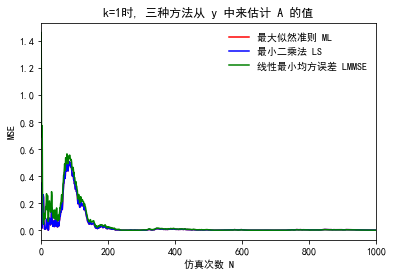

In [96]:
ml_mses, ls_mses, lmmse_mses = kth_mse[1]

# 仿真
epochs = np.array(epochs)
# ml_mses = np.array(ml_mses)

fig, ax = plt.subplots(1, 1)
ax.set_xlim([epochs.min(), epochs.max()])
ax.plot(epochs.ravel(), ml_mses, 'r-', label='最大似然准则 ML')
ax.plot(epochs.ravel(), ls_mses, 'b-', label='最小二乘法 LS')
ax.plot(epochs.ravel(), lmmse_mses, 'g-', label='线性最小均方误差 LMMSE')

ax.legend(loc='best', frameon=False)
plt.title("k=1时, 三种方法从 y 中来估计 A 的值")
plt.xlabel("仿真次数 N")
plt.ylabel("MSE")
plt.show()

##### k=2,4,6,8,10,12,14,16

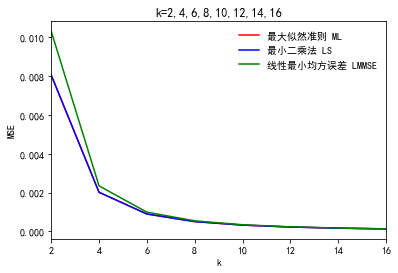

In [95]:
x = []
y_ml_mse = []
y_ls_mse = []
y_lmmse_mse = []
for k in [2,4,6,8,10,12,14,16]:
    ml_mses, ls_mses, lmmse_mses = kth_mse[k]
    x.append(k)
    y_ml_mse.append(np.mean(ml_mses))
    y_ls_mse.append(np.mean(ls_mses))
    y_lmmse_mse.append(np.mean(lmmse_mses))

# 仿真
x = np.array(x)
fig, ax = plt.subplots(1, 1)
ax.set_xlim([x.min(), x.max()])
ax.plot(x.ravel(), y_ml_mse, 'r-', label='最大似然准则 ML')
ax.plot(x.ravel(), y_ls_mse, 'b-', label='最小二乘法 LS')
ax.plot(x.ravel(), y_lmmse_mse, 'g-', label='线性最小均方误差 LMMSE')

ax.legend(loc='best', frameon=False)
plt.title("k=2,4,6,8,10,12,14,16")
plt.xlabel("k")
plt.ylabel("MSE")
plt.show()
